In [118]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet

In [119]:
data = pd.read_csv("/content/drive/MyDrive/IOT/(Segunda) PB/TP9/room_temp_rawdata.csv")
data = data.fillna(0)
data

,Timestamp,Temperature_Celsius,Relative_Humidity
0,2021-01-09 12:22:54,13.4,55
1,2021-01-09 12:24:58,15.8,46
2,2021-01-09 12:26:58,17.3,45
3,2021-01-09 12:29:01,19.0,42
4,2021-01-09 12:31:16,20.1,39
...,...,...,...
7011,2021-05-14 11:51:53,25.5,52
7012,2021-05-14 12:21:58,25.4,52
7013,2021-05-14 12:52:00,25.4,52
7014,2021-05-14 13:22:06,25.6,51


In [120]:
data['Timestamp'] = pd.to_datetime(data.Timestamp)
data.dtypes

Timestamp              datetime64[ns]
Temperature_Celsius           float64
Relative_Humidity               int64
dtype: object

In [121]:
# Remove Outliers
q = data["Temperature_Celsius"].quantile(0.99)

q_low = data["Temperature_Celsius"].quantile(0.01)
q_hi  = data["Temperature_Celsius"].quantile(0.99)

df_filtered = data[(data["Temperature_Celsius"] < q_hi) & (data["Temperature_Celsius"] > q_low)]

In [122]:
plotdf = df_filtered.copy()
plotdf['Temperature_Celsius'] = plotdf['Temperature_Celsius']

Text(0.5, 1.0, 'Temperatura ao longo dos meses')

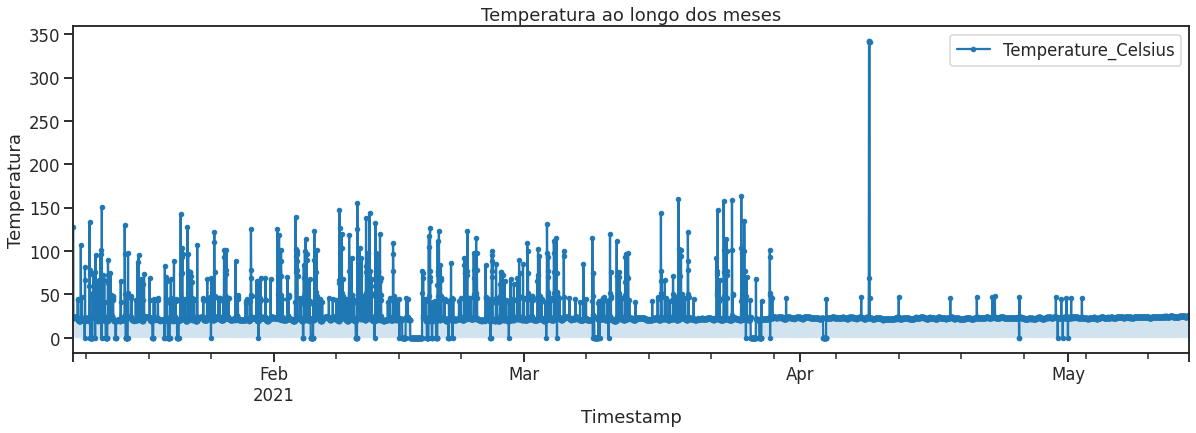

In [123]:
df = plotdf[['Timestamp', 'Temperature_Celsius']]
df.set_index('Timestamp', inplace=True)
df = df.resample('30min').sum()
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
df.plot(ax=ax, marker='.')
ax.fill_between(df.index, df['Temperature_Celsius'] , alpha=.2)
ax.set_ylabel("Temperatura")
ax.set_title("Temperatura ao longo dos meses")

In [124]:
train = df[df.index <= '2021-04-01']
test = df[df.index >= '2021-04-01']

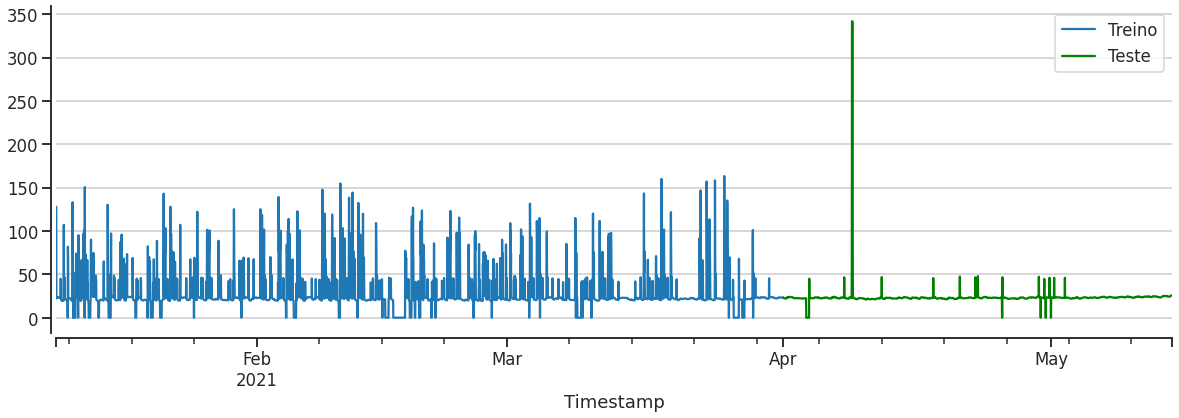

In [125]:
fig, ax= plt.subplots(1, 1, figsize=(20, 6))
sns.set_style("ticks")
sns.set_context("talk")

train.plot(ax=ax)
test.plot(ax=ax, c="g")
ax.yaxis.grid(True)
ax.legend(["Treino", "Teste"])
sns.despine(offset=5, trim=False)

In [126]:
train_prophet = train.reset_index().rename(columns={'Timestamp': 'ds', 'Temperature_Celsius': 'y'})
train_prophet.head()

,ds,y
0,2021-01-09 12:30:00,127.9
1,2021-01-09 13:00:00,22.3
2,2021-01-09 13:30:00,22.8
3,2021-01-09 14:00:00,23.1
4,2021-01-09 14:30:00,23.3


In [127]:
model = Prophet(yearly_seasonality=4, seasonality_mode="multiplicative")
model.fit(train_prophet)

In [129]:
periods = df.shape[0] - train.size
print(periods)
future = model.make_future_dataframe(periods=periods, freq="30min")
forecast = model.predict(future)
forecast.tail()

2091


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
5998,2021-05-14 11:30:00,9.124793,-19.386057,28.938381,4.615847,13.726188,0.168019,0.168019,0.168019,-0.413513,...,0.099887,0.099887,0.099887,-0.681419,-0.681419,-0.681419,0.0,0.0,0.0,5.351568
5999,2021-05-14 12:00:00,9.120270,-19.545296,27.999716,4.606386,13.723989,0.070404,0.070404,0.070404,-0.516698,...,0.094320,0.094320,0.094320,-0.681422,-0.681422,-0.681422,0.0,0.0,0.0,4.407842
6000,2021-05-14 12:30:00,9.115747,-20.863754,29.220290,4.598015,13.721790,-0.000602,-0.000602,-0.000602,-0.593345,...,0.088681,0.088681,0.088681,-0.681424,-0.681424,-0.681424,0.0,0.0,0.0,3.706967
6001,2021-05-14 13:00:00,9.111224,-20.775479,26.852078,4.589737,13.719592,-0.032939,-0.032939,-0.032939,-0.631385,...,0.082979,0.082979,0.082979,-0.681425,-0.681425,-0.681425,0.0,0.0,0.0,3.358534
6002,2021-05-14 13:30:00,9.106702,-20.790388,26.833096,4.581583,13.717393,-0.023555,-0.023555,-0.023555,-0.627761,...,0.077220,0.077220,0.077220,-0.681426,-0.681426,-0.681426,0.0,0.0,0.0,3.389872


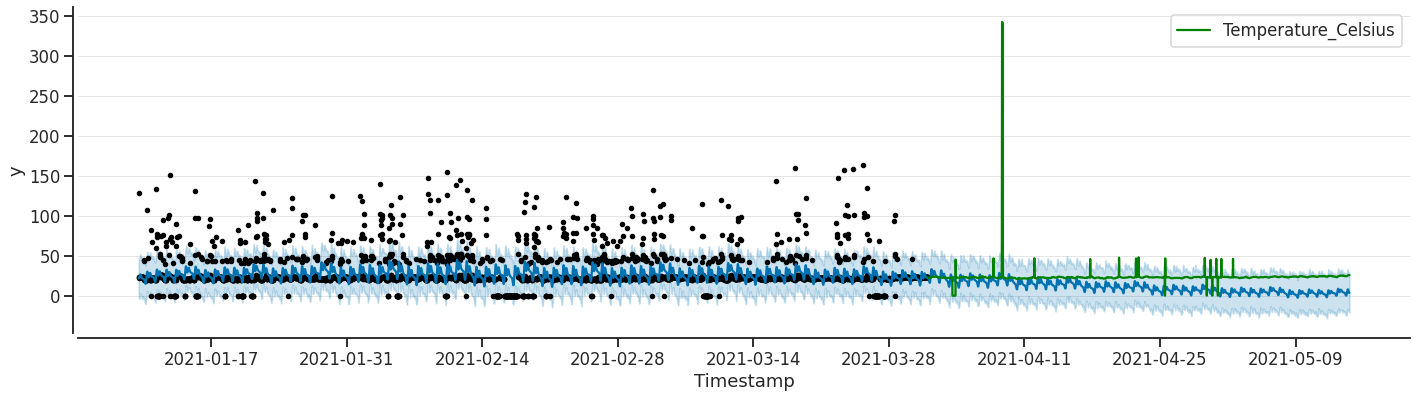

In [130]:
fig, ax= plt.subplots(1, 1, figsize=(20, 6))
sns.set_style("ticks")

sns.set_context("talk")
model.plot(forecast, ax=ax);

test.plot(ax=ax, c="g");
ax.yaxis.grid(True)

sns.despine(offset=5, trim=False)

In [131]:
from sklearn.metrics import mean_squared_error, r2_score

yhat_test = forecast.yhat[train.size -1:]

print("R2 Score: ", r2_score(test, yhat_test))
print("MSE: ", mean_squared_error(test, yhat_test))
print("RMSE: ", mean_squared_error(test, yhat_test, squared=False))

R2 Score:  -0.9707202172050842
MSE:  402.436875888414
RMSE:  20.06082939183757
